In [2]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.mkdir(ASSETS_DIR, exist_ok=True) # или os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

TypeError: 'exist_ok' is an invalid keyword argument for mkdir()

In [18]:
import os
from dotenv import load_dotenv
load_dotenv()

connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df[:2]

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,2043,7361-YPXFS,2017-10-01,NaT,Month-to-month,No,Bank transfer (automatic),64.45,1867.6,DSL,...,Yes,Yes,No,No,Female,1,No,No,Yes,0
1,2044,6557-BZXLQ,2018-10-01,NaT,Month-to-month,No,Electronic check,69.65,1043.3,Fiber optic,...,No,No,No,No,Male,1,No,No,No,0


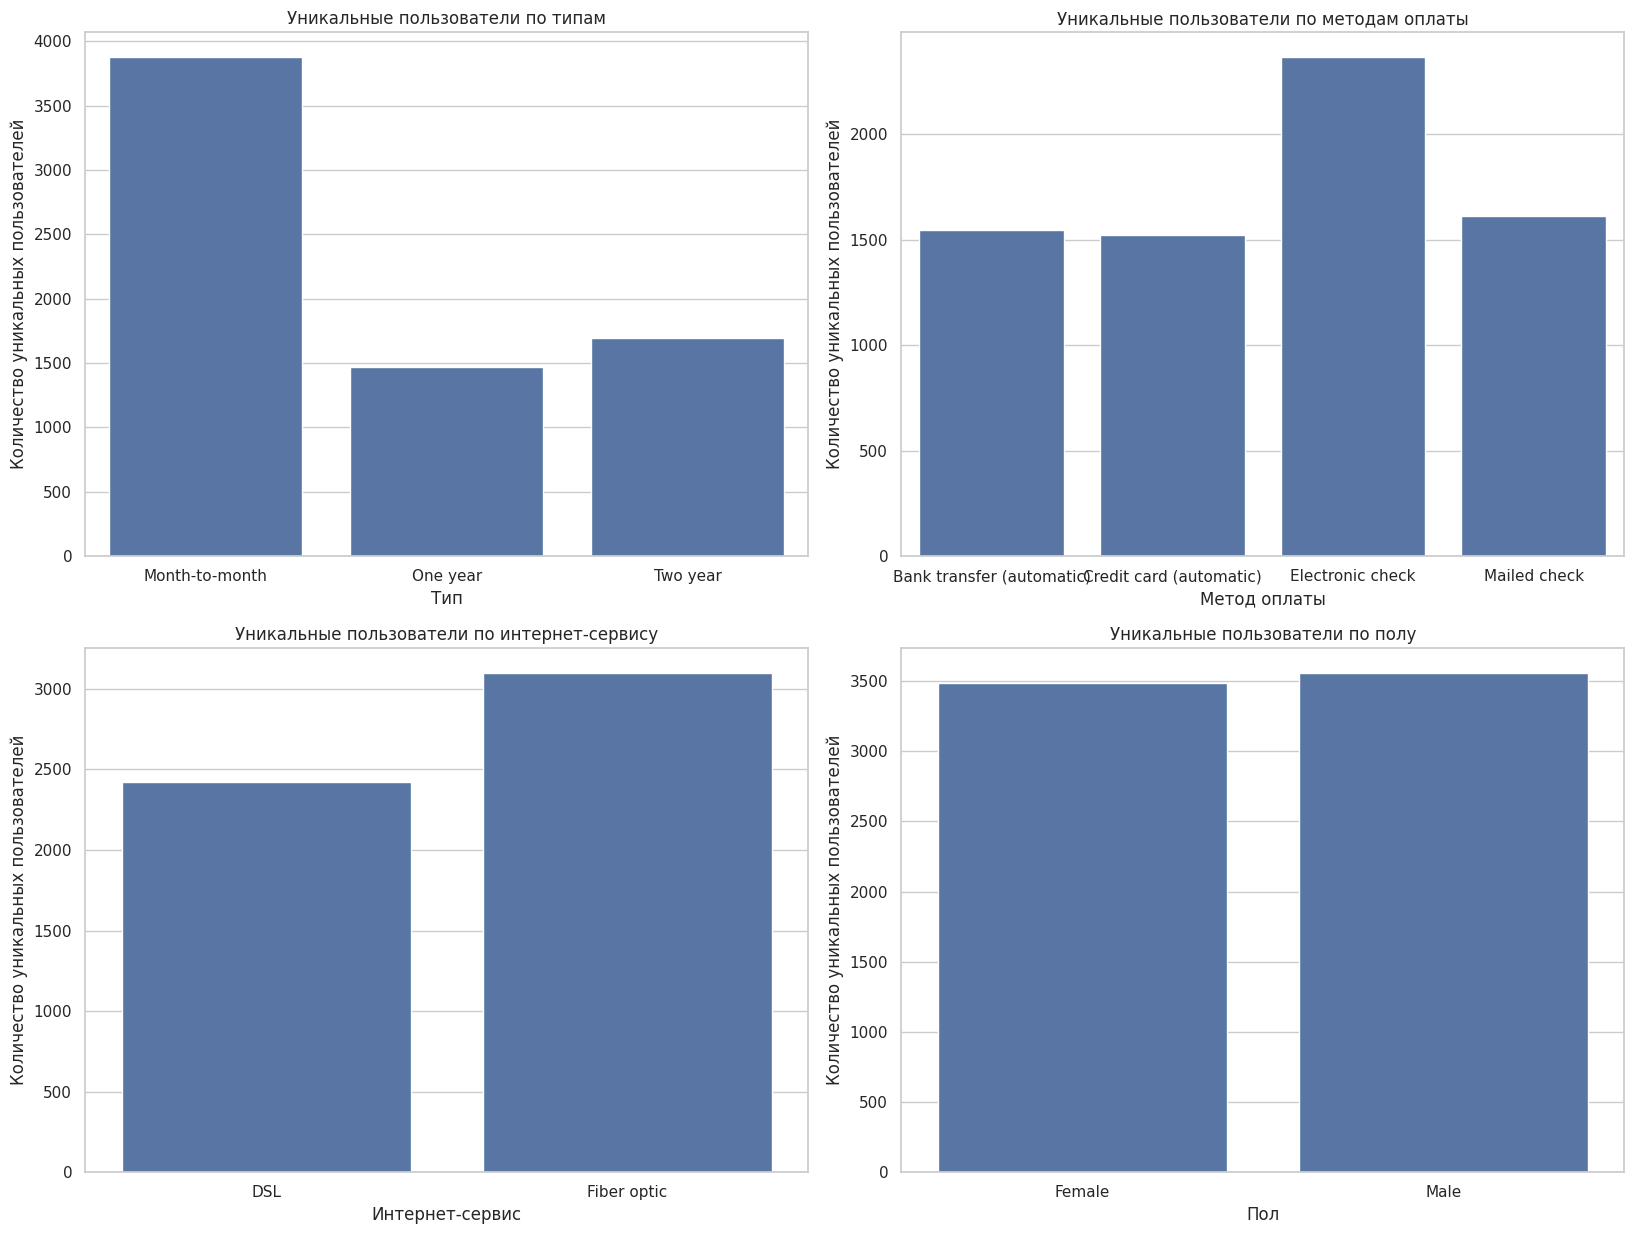

In [31]:
# Уникальные пользователи по различным категориям
unique_users_by_type = df.groupby('type')['customer_id'].nunique()
unique_users_by_payment_method = df.groupby('payment_method')['customer_id'].nunique()
unique_users_by_internet_service = df.groupby('internet_service')['customer_id'].nunique()
unique_users_by_gender = df.groupby('gender')['customer_id'].nunique()

# Создайте фигуру с четырьмя подграфиками
plt.figure(figsize=(16.5, 12.5))

# График для 'type'
plt.subplot(2, 2, 1)
sns.barplot(x=unique_users_by_type.index, y=unique_users_by_type.values)
plt.title('Уникальные пользователи по типам')
plt.xlabel('Тип')
plt.ylabel('Количество уникальных пользователей')

# График для 'payment_method'
plt.subplot(2, 2, 2)
sns.barplot(x=unique_users_by_payment_method.index, y=unique_users_by_payment_method.values)
plt.title('Уникальные пользователи по методам оплаты')
plt.xlabel('Метод оплаты')
plt.ylabel('Количество уникальных пользователей')

# График для 'internet_service'
plt.subplot(2, 2, 3)
sns.barplot(x=unique_users_by_internet_service.index, y=unique_users_by_internet_service.values)
plt.title('Уникальные пользователи по интернет-сервису')
plt.xlabel('Интернет-сервис')
plt.ylabel('Количество уникальных пользователей')

# График для 'gender'
plt.subplot(2, 2, 4)
sns.barplot(x=unique_users_by_gender.index, y=unique_users_by_gender.values)
plt.title('Уникальные пользователи по полу')
plt.xlabel('Пол')
plt.ylabel('Количество уникальных пользователей')

# Автоматически подстраиваем подграфики
plt.tight_layout()

# Сохранение графика в директорию ASSETS_DIR
ASSETS_DIR = "assets"  # Замените на ваш путь
plt.savefig(f"{ASSETS_DIR}/cat_features_1.png")

# Показать график
plt.show()

In [56]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]

# Подсчет количества пользователей для каждой бинарной колонки
stat = ['count']

# Вывод первых 10 строк
print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))
#print(df.groupby(binary_columns).agg(count=('customer_id', 'count')).reset_index().sort_values(by='count', ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv  \
0                No            No                No           No           No   
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

/tmp/ipykernel_3051/3734706459.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat_df = df[binary_columns].replace({'Yes': 1, 'No': 0})


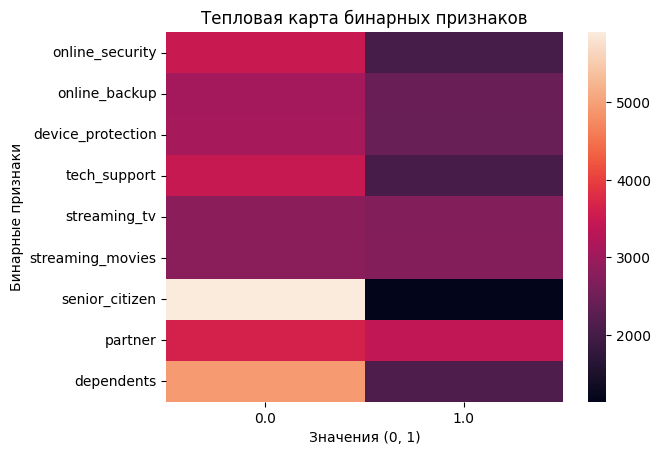

In [15]:
# Объявление бинарных колонок
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]

heat_df = df[binary_columns].replace({'Yes': 1, 'No': 0})
#heat_df = df[binary_columns].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# Создание тепловой карты
heat_df = heat_df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df, fmt="d")

plt.title('Тепловая карта бинарных признаков')
plt.xlabel('Значения (0, 1)')
plt.ylabel('Бинарные признаки')
#plt.xticks(rotation=0)
#plt.tight_layout()

# Сохранение графика в директорию с артефактами
plt.savefig(f"{ASSETS_DIR}/cat_features_2_binary_heatmap.png")
plt.show()

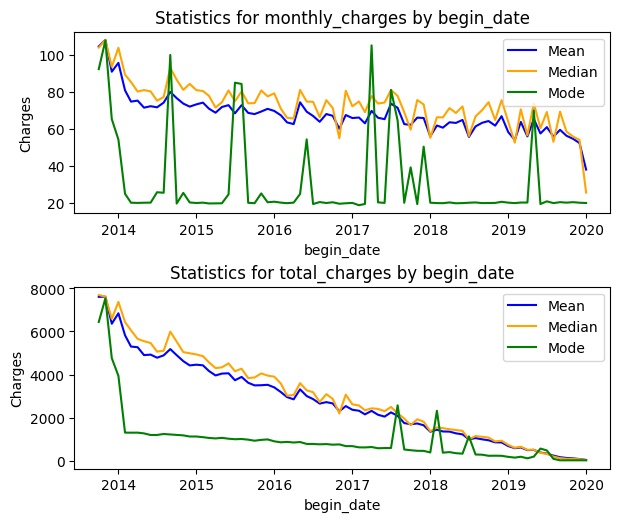

In [21]:
x = "begin_date"

# Список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# Удаление пустых колонок для подсчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)

# Список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# Группировка данных по дате начала и агрегация статистик для ежемесячных платежей
charges_monthly_agg = df.groupby(x)[charges_columns[0]].agg(stats).reset_index()
#charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# Аналогично для общих платежей
charges_total_agg = df.groupby(x)[charges_columns[1]].agg(stats).reset_index()
#charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# Создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)

# Настройка отступов между графиками
fig.tight_layout(pad=2.5)

# Установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# Построение линейных графиков для ежемесячных платежей
axs[0].plot(charges_monthly_agg[x], charges_monthly_agg["monthly_mean"], label='Mean', color='blue')
axs[0].plot(charges_monthly_agg[x], charges_monthly_agg["monthly_median"], label='Median', color='orange')
axs[0].plot(charges_monthly_agg[x], charges_monthly_agg["monthly_mode"], label='Mode', color='green')
axs[0].set_title(f"Statistics for {charges_columns[0]} by {x}")
axs[0].set_xlabel(x)
axs[0].set_ylabel('Charges')
axs[0].legend()

# Построение линейных графиков для общих платежей
axs[1].plot(charges_total_agg[x], charges_total_agg["total_mean"], label='Mean', color='blue')
axs[1].plot(charges_total_agg[x], charges_total_agg["total_median"], label='Median', color='orange')
axs[1].plot(charges_total_agg[x], charges_total_agg["total_mode"], label='Mode', color='green')
axs[1].set_title(f"Statistics for {charges_columns[1]} by {x}")
axs[1].set_xlabel(x)
axs[1].set_ylabel('Charges')
axs[1].legend()

# Сохранение графика в файл
plt.savefig(f"{ASSETS_DIR}/charges_by_date.png")
plt.show()

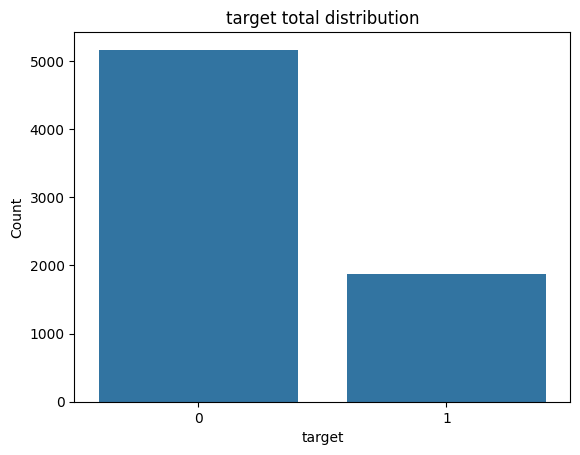

In [32]:
# Директория для сохранения картинок
#ASSETS_DIR = "path/to/your/assets/directory"  # Замените на ваш путь

# Установка названия колонки для агрегации
x = "target"

# Подсчет количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()
#target_agg.columns = [x, 'count']  # Переименование колонок
target_agg[:10]

# Создание столбчатой диаграммы для визуализации распределения целевой переменной
#plt.figure(figsize=(8, 5))
sns.barplot(data=target_agg, x='target', y='count')

# Установка заголовка графика
plt.title(f"{x} total distribution")
plt.xlabel(x)
plt.ylabel('Count')

# Сохранение графика в файл
plt.savefig(f"{ASSETS_DIR}/target_count.png")  # Укажите полный путь, если необходимо
plt.show()

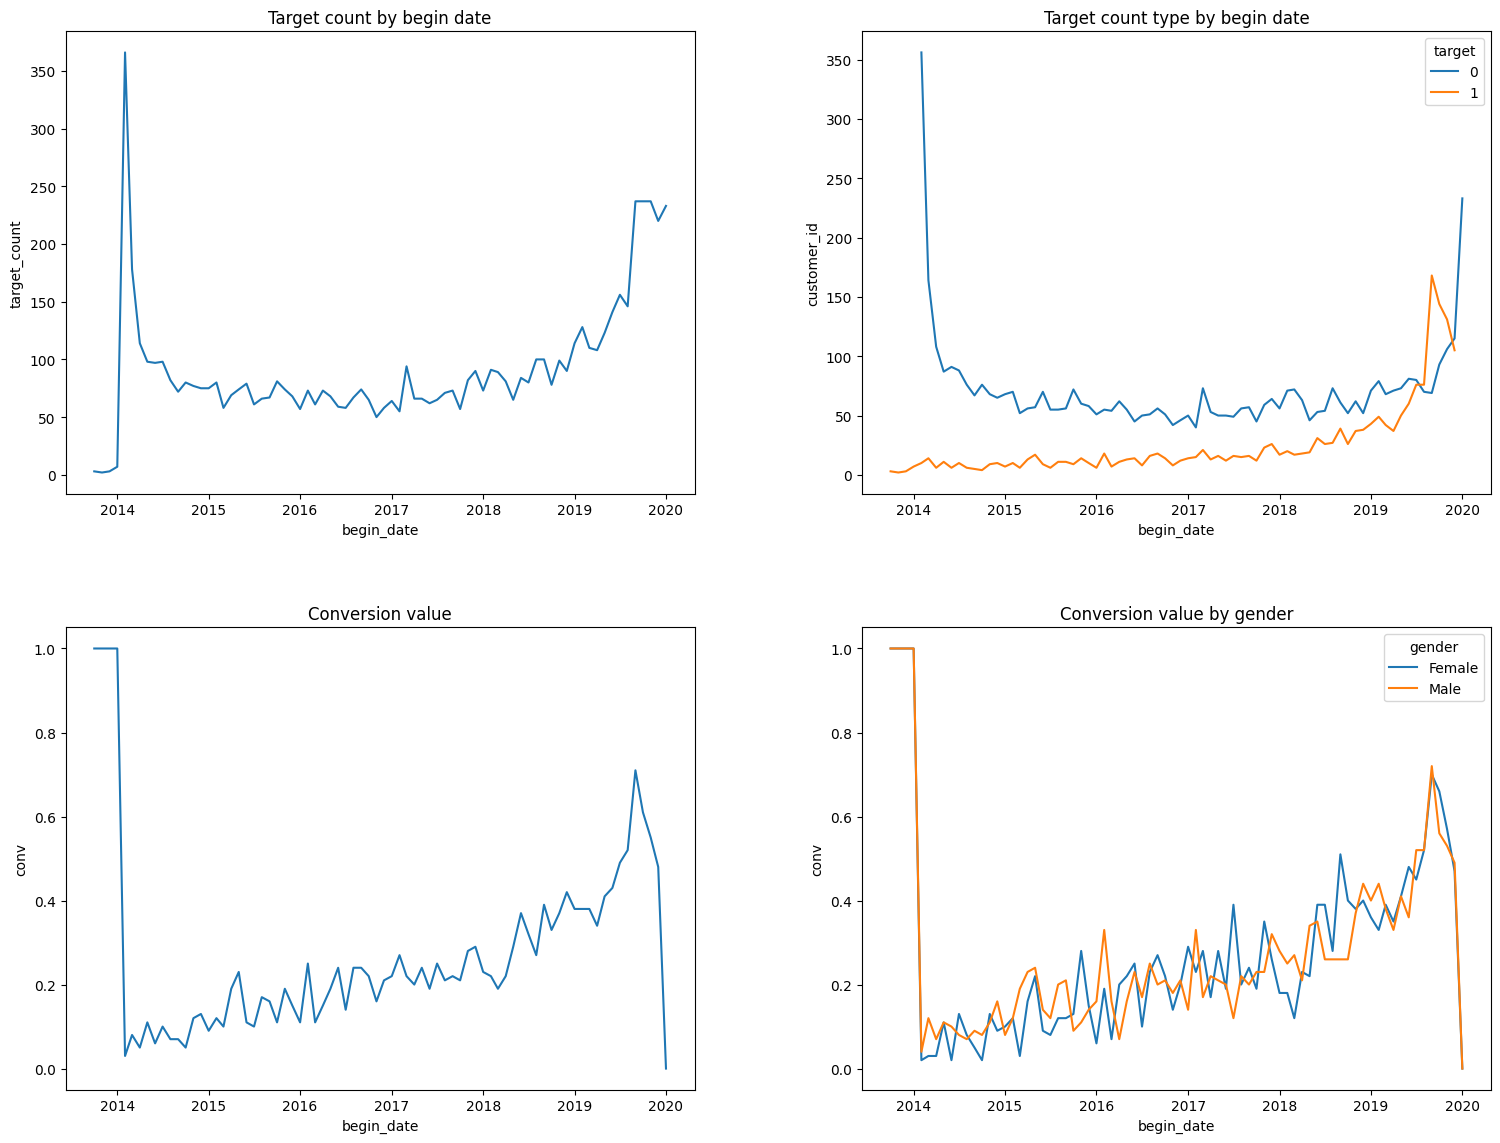

In [37]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)

# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender['conv'] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
# ваш код здесь #
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
# ваш код здесь #
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
# ваш код здесь #
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
# ваш код здесь #
sns.lineplot(data=conversion_agg_gender, x=x, y='conv', hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date.png'))
plt.show()

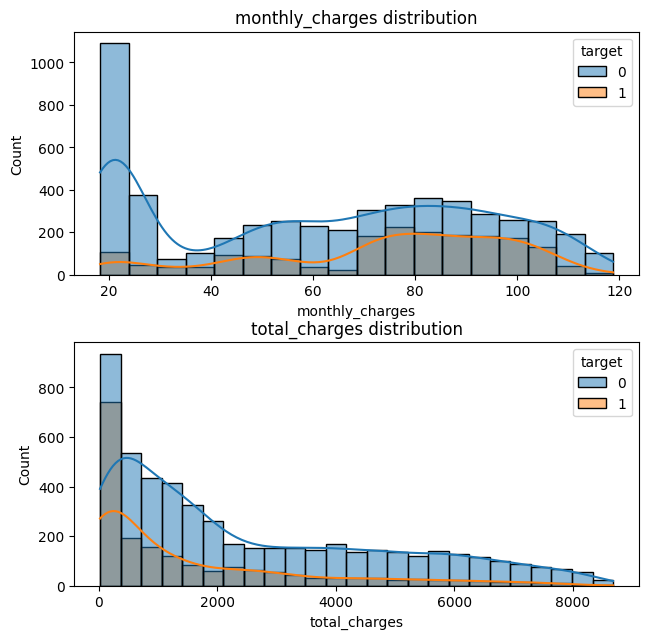

In [38]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
# датафрейм с данными
# первый вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения (Kernel Density Estimate)
# указание, на каком подграфике отобразить гистограмму
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
# ваш код здесь #
# датафрейм с данными
# второй вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения
# указание, на каком подграфике отобразить вторую гистограмму
sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))
plt.show()

In [40]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)